# import

In [13]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# find session with good trace

In [2]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.head()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LM = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_V1 = meta.copy()

meta = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ]
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta_LI = meta.copy()

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# meta

area
LM    22
Name: count, dtype: int64 22
area
V1    6
Name: count, dtype: int64 6
area
LI    18
Name: count, dtype: int64 18


In [4]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)):
    # print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = '00' + meta.loc[iset, 'num'].astype(str)
    sess = meta.loc[iset, 'num']
    # print(imouse, date, area, sess)
    dir_identifier = f'{area}_{imouse}_{date}_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
clear_output()

# print(df_tidy.mouse.unique(), 
#       df_tidy.date.unique(), 
#       df_tidy.sess.unique(), 
#       df_tidy.area.unique(), 
#       df_tidy.isi.unique(), 
#       df_tidy.stim1_contrast.unique(), 
#       df_tidy.stim2_id.unique(), 
#       df_tidy.resp_id.unique())
# df_tidy.sample(5, random_state=0)

In [10]:
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)
df_tidy[(df_tidy.area == 'V1')].groupby('datesess').filter_cell_vis.sum().sort_values(ascending=False).head()

datesess
200803_002    74072
200728_003    70650
201209_002    61464
201015_004    52140
200720_003    50176
Name: filter_cell_vis, dtype: int64

# load session

In [50]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_sess_trace = os.path.join(dir_mat_inter, 'V1_i1322_200803_002/trace_trial_stim.mat')

trace = sio.loadmat(dir_sess_trace)
trace_by_trial = trace['trace_by_trial']
ncell = trace_by_trial.shape[0]
ntrial = trace_by_trial.shape[1]
nframe = trace_by_trial.shape[2]

print(f'ncell={ncell}, ntrial={ntrial}, nframe={nframe}')

ncell=97, ntrial=463, nframe=207


## find cells with large adp and R2

In [52]:
R2 = (df_tidy[(df_tidy.datesess == '200803_002') 
        & (df_tidy.filter_cell_vis == True) 
        & (df_tidy.stim2_id == 0)
        & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R2'}))

R1 = (df_tidy[(df_tidy.datesess == '200803_002') 
        & (df_tidy.filter_cell_vis == True) 
        & (df_tidy.stim2_id == 0)
        & ( 
        #    ((df_tidy.isi == 6000) & (df_tidy.resp_id == 'R2')) | 
           (df_tidy.resp_id == 'R1') )
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R1'}))

df_adp = pd.merge(R1, R2, on='cell_id')
df_adp['adp'] = (df_adp.R2 - df_adp.R1) / (df_adp.R1 + 1e-7)
df_adp = df_adp[(df_adp.R1 > 0) & (df_adp.R2 > 0.1)].sort_values('adp', ascending=True).reset_index(drop=True)
df_adp.head(10) # 200803_002_4 is good to plot, bc obvious adp and large R2

,cell_id,R1,R2,adp
0,200803_002_4,0.231372,0.108640,-0.530452
1,200803_002_59,0.223507,0.133223,-0.403944
2,200803_002_72,0.222016,0.135350,-0.390361
3,200803_002_84,0.266118,0.162273,-0.390223
4,200803_002_89,0.303029,0.185989,-0.386234
5,200803_002_83,0.255223,0.156873,-0.385348
6,200803_002_9,0.205501,0.130879,-0.363122
7,200803_002_18,0.162925,0.107738,-0.338728
8,200803_002_70,0.181962,0.125656,-0.309436
9,200803_002_56,0.192650,0.144773,-0.248516


In [83]:
## select example cells

cell_id = df_adp.head(10).cell_id.values
cell_id = [item.split('_')[-1] for item in cell_id]
cell_id = [int(item) for item in cell_id]
cell_id

[4, 59, 72, 84, 89, 83, 9, 18, 70, 56]

In [84]:
## select example trials (stim2 = 0, isi = 250, resp_id = R2)

trial_id = df_tidy[(df_tidy.datesess == '200803_002') 
            & (df_tidy.stim2_id == 0)
            & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
            ].trial_id.unique()
trial_id

array([ 23,  45,  50,  76,  80, 117, 127, 138, 153, 166, 192, 225, 227,
       266, 284, 301, 329, 392, 417, 418, 428], dtype=int64)

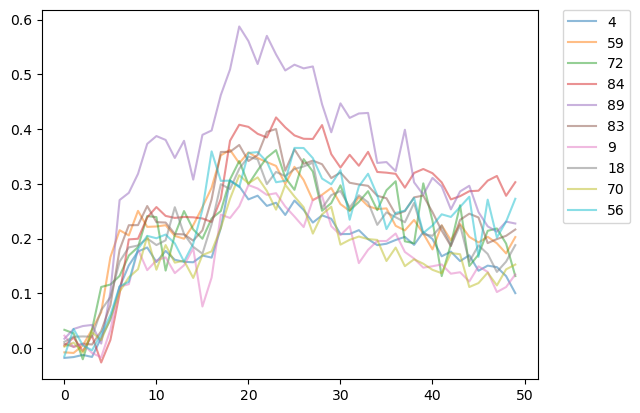

In [85]:
## choose cell by nice avg trace 

for icell in cell_id:
    trace_avg_cell = trace_by_trial[icell, trial_id, :50].mean(axis=0)
    plt.plot(trace_avg_cell, alpha=0.5);
plt.legend(cell_id, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

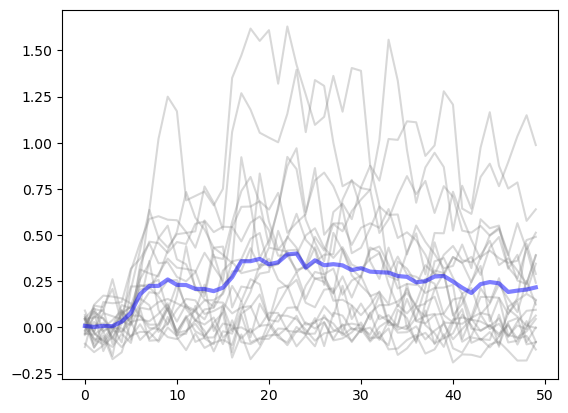

In [102]:
single_cell_id = 83

for itrial in trial_id:
    trace_trial = trace_by_trial[single_cell_id, itrial, :50]
    plt.plot(trace_trial, alpha=0.3, color='gray');

trace_avg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
plt.plot(trace_avg_cell, alpha=0.5, linewidth=3, color='b');